In [1]:
# Import Packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

# Metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Pickle results
import pickle

# Display all columns
pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


Summary of business task: Stakeholder has bank data on customers and wants a prediction on each customer and their probability of churning.

Format:

id ,  Exited

165034, .9

165035, .8

In [2]:
## Import test data
df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [4]:
df.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [5]:
# Check for null data
df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# Get count and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [7]:
# Get summary statistics
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [8]:
# Drop irrelevant or ethically ambiguous classes
df1 = df.drop(['Age', 'Surname', 'Gender', 'CustomerId'], axis=1)

In [9]:
# Rename columns to snakecase, except Exited (in desired format)
df1 = df1.rename(columns = {'Balance' : 'balance', 'NumOfProducts' : 'num_products', 'HasCrCard' : 'cc', 
                            'IsActiveMember' : 'active', 'EstimatedSalary' : 'salary', 'Geography' : 'geo'})

In [10]:
# Get dummies for Geography
df1 = pd.get_dummies(df1)
df1.head()

,id,CreditScore,Tenure,balance,num_products,cc,active,salary,Exited,geo_France,geo_Germany,geo_Spain
0,0,668,3,0.00,2,1.0,0.0,181449.97,0,True,False,False
1,1,627,1,0.00,2,1.0,1.0,49503.50,0,True,False,False
2,2,678,10,0.00,2,1.0,0.0,184866.69,0,True,False,False
3,3,581,2,148882.54,1,1.0,1.0,84560.88,0,True,False,False
4,4,716,5,0.00,2,1.0,1.0,15068.83,0,False,False,True


In [11]:
# Rename dummies to snakecase
df1 = df1.rename(columns = {'geo_France' : 'geo_fr', 'geo_Germany' : 'geo_ger', 'geo_Spain' : 'geo_sp'})

In [12]:
# Binary code geography columns
df1 = df1.astype({'geo_fr' : int, 'geo_ger' : int, 'geo_sp' : int})

In [13]:
df1.head()

,id,CreditScore,Tenure,balance,num_products,cc,active,salary,Exited,geo_fr,geo_ger,geo_sp
0,0,668,3,0.00,2,1.0,0.0,181449.97,0,1,0,0
1,1,627,1,0.00,2,1.0,1.0,49503.50,0,1,0,0
2,2,678,10,0.00,2,1.0,0.0,184866.69,0,1,0,0
3,3,581,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0
4,4,716,5,0.00,2,1.0,1.0,15068.83,0,0,0,1


In [14]:
# Feature engineer 3 different tenure classes and binary code them.
# Create classes
df1['new'] = df1['Tenure'].copy()

df1['middle'] = df1['Tenure'].copy()

df1['old'] = df1['Tenure'].copy()


In [15]:
# Make conversion function for young
def new (year):
    if year['new'] <= 3 :
        val = 1
    else:
        val = 0
    return val

# Apply function
df1['new'] = df1.apply(new, axis=1)

# Make conversion function for middle
def middle (year):
    if 3 < year['middle'] <= 6:
        val = 1
    else:
        val = 0
    return val
# Apply function
df1['middle'] = df1.apply(middle, axis=1)

# Make conversion function for old
def old (year):
    if year['old'] > 6:
        val = 1
    else:
        val = 0
    return val
# Apply function
df1['old'] = df1.apply(old, axis=1)

In [16]:
# Check dataframe
df1.head()

,id,CreditScore,Tenure,balance,num_products,cc,active,salary,Exited,geo_fr,geo_ger,geo_sp,new,middle,old
0,0,668,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,1,0,0
1,1,627,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,1,0,0
2,2,678,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,0,1
3,3,581,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,1,0,0
4,4,716,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0


In [17]:
# Drop tenure, features engineered
df1 = df1.drop(['Tenure'], axis = 1)

<Axes: >

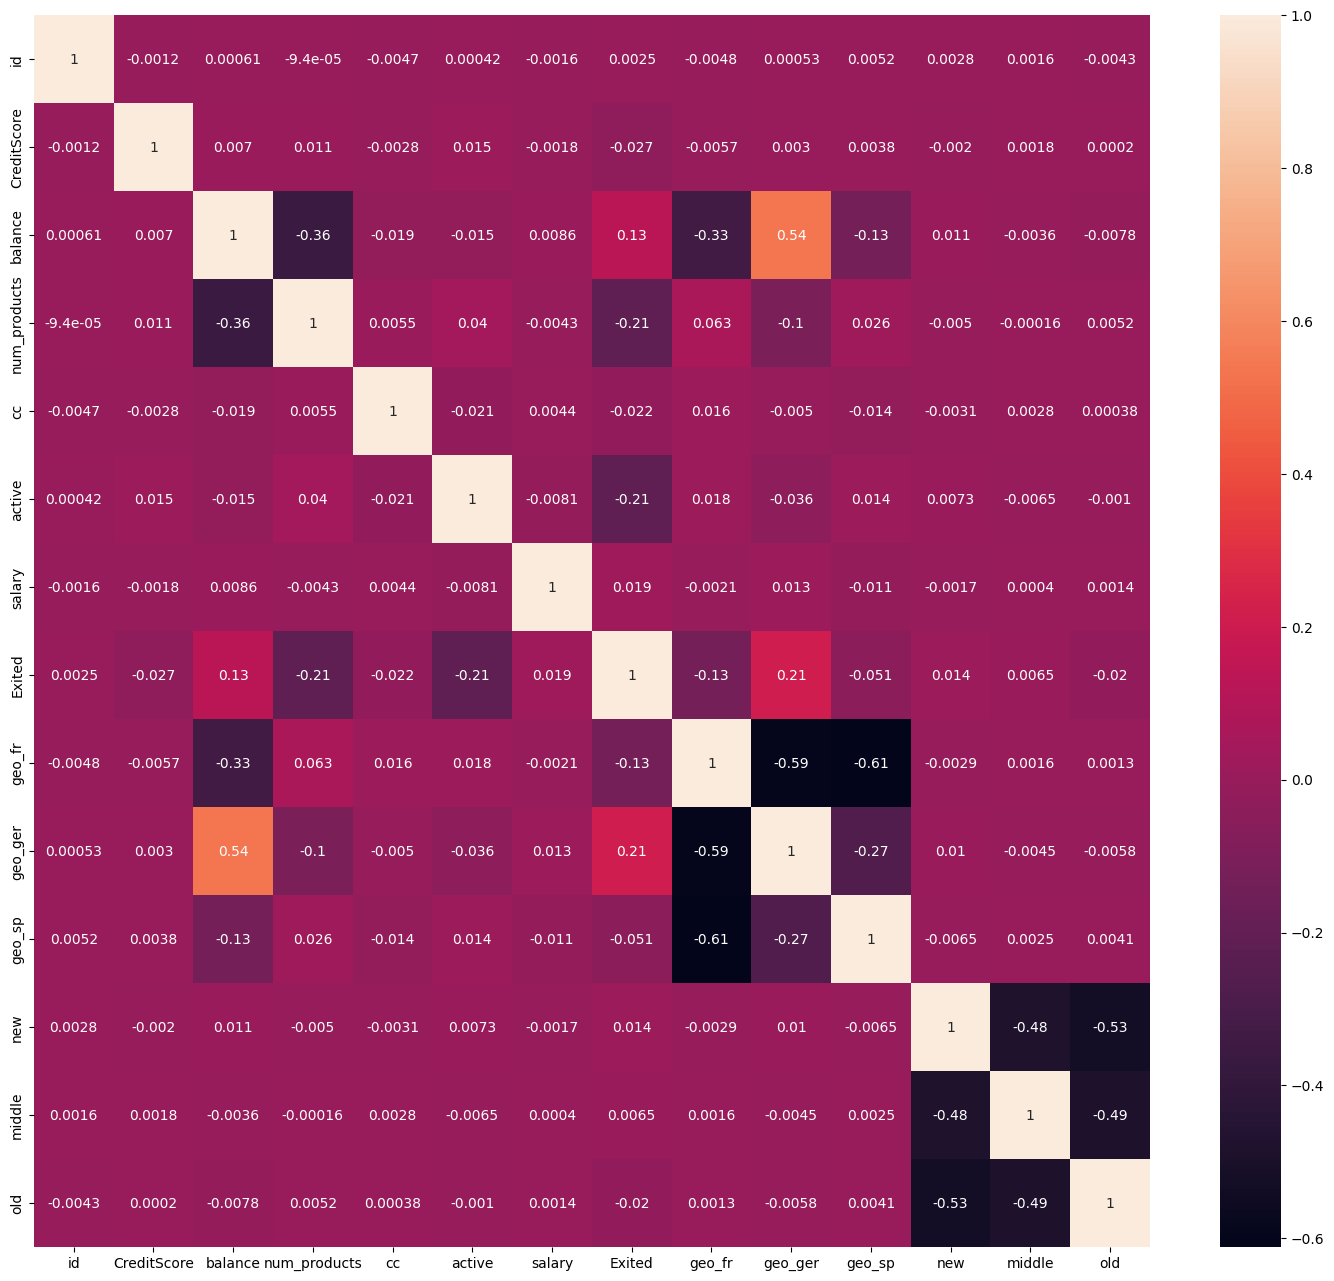

In [18]:
# Use heatmat correlation to examine direct impact of other variables on Exited
plt.figure(figsize = (18,16))
sns.heatmap(df1.corr(), annot=True)

Heatmap summary: 
Key correlations to Exited - balance (positive correlation), num_products (negative correlation), active (negative correlation), geo_fr (negative correlation), geo_ger (positive correlation)

<Axes: xlabel='num_products', ylabel='Exited'>

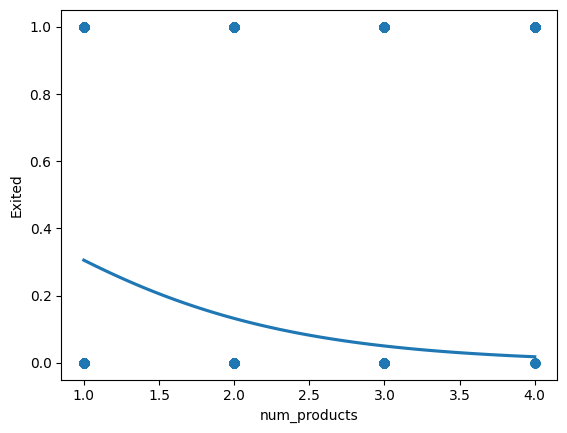

In [19]:
# Plot most relevant variable
sns.regplot(x='num_products', y='Exited', data = df1, 
            logistic = True, ci = None)

Now that we've done some preliminary exploration and feature engineering, it's time to build our model and evaluate it.

In [20]:
# Define target and predictor variables
y = df1['Exited']

X = df1.drop(['Exited'], axis=1)

In [21]:
# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,
                                                   stratify = y, random_state = 0)


In [22]:
# Assign XGBClassifier to variable
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0)


In [23]:
# Define tuning parameters
cv_params = {'max_depth' : [6,8],
            'min_child_weight': [20,40],
            'learning_rate': [.1,.2,.3],
            'n_estimators' : [100, 150, 200],
            'subsample': [.7, .8],
            'colsample_bytree': [.7, .8]}

In [24]:
# Define scoring criteria
scoring = {'accuracy', 'recall' , 'precision' ,'f1'}

In [25]:
# Construct Grid Search cross-validation
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring,
                      cv = 5, refit='f1')

In [26]:
%%time
# Fit Grid Search model to training data

xgb_cv.fit(X_train, y_train)

CPU times: user 1h 5min 12s, sys: 12.9 s, total: 1h 5min 25s
Wall time: 17min 37s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [6, 8],
                         'min_child_weight': [20, 40],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.7, 0.8]},
             refit='f1', scoring={'precision', 'f1', 'recall', 'accuracy'})

In [27]:
# Find best parameters
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 40,
 'n_estimators': 100,
 'subsample': 0.7}

In [28]:
#Pickle save the model
pickle.dump(xgb_cv, open('xgb.sav', 'wb'))

In [29]:
# Check metrics on prediction model
y_pred = xgb_cv.predict(X_test)

# Print test metric scores
ac_score = accuracy_score(y_test,y_pred)
print('Accuracy score XGB model: ', ac_score)

pc_score = precision_score(y_test,y_pred)
print('Precision score XGB model: ', pc_score)

rc_score = recall_score(y_test,y_pred)
print('Recall score XGB model: ', rc_score)

f1_metric = f1_score(y_test,y_pred)
print('f1 score XGB model: ', f1_metric)

Accuracy score XGB model:  0.8316417729572515
Precision score XGB model:  0.6404251131666995
Recall score XGB model:  0.465922107674685
f1 score XGB model:  0.539411520928305


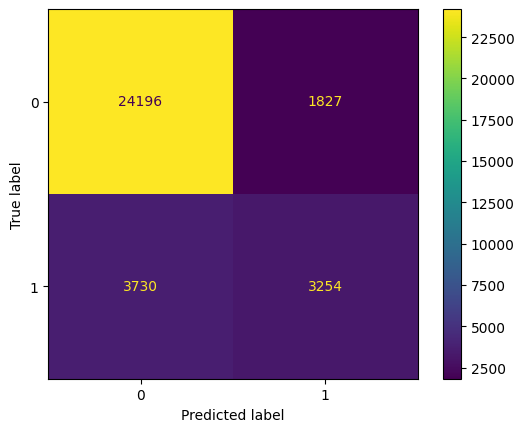

In [30]:
# Make confusion matrix to see results by numbers
def conf_matrix (model, x_data, y_data):
    
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = model.classes_)
    # Create display and make values non-scientific
    disp.plot(values_format = '')
    # Plot visual in-line
    plt.show()
    
# Apply confusion matrix for model and test values
conf_matrix(xgb_cv, X_test, y_test)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

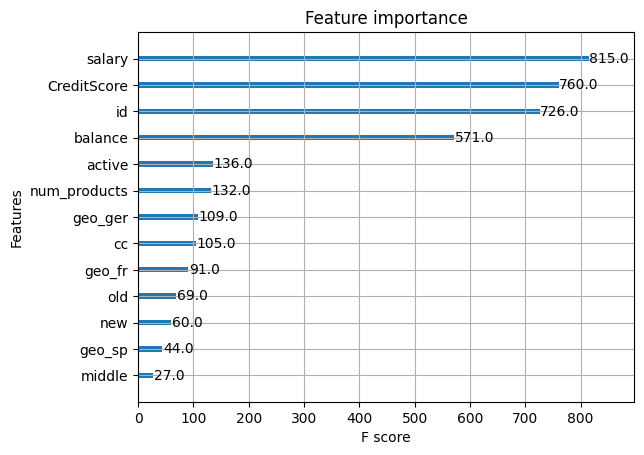

In [31]:
# Determine importance of features
plot_importance(xgb_cv.best_estimator_)



Model appears to be struggling due to class imbalance. Implement synthetic minority oversampling technique.



In [32]:
# Import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

In [33]:
# Define new smote X and y
X_smote, y_smote = smote.fit_resample(X,y)
X_smote.head()

,id,CreditScore,balance,num_products,cc,active,salary,geo_fr,geo_ger,geo_sp,new,middle,old
0,0,668,0.00,2,1.0,0.0,181449.97,1,0,0,1,0,0
1,1,627,0.00,2,1.0,1.0,49503.50,1,0,0,1,0,0
2,2,678,0.00,2,1.0,0.0,184866.69,1,0,0,0,0,1
3,3,581,148882.54,1,1.0,1.0,84560.88,1,0,0,1,0,0
4,4,716,0.00,2,1.0,1.0,15068.83,0,0,1,0,1,0


In [34]:
# Define new X and y
X = X_smote
y = y_smote
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,
                                                   stratify = y, random_state = 0)

In [35]:
%%time
# Fit Grid Search model to training data

xgb_cv.fit(X_train, y_train)

CPU times: user 1h 39min 1s, sys: 17 s, total: 1h 39min 18s
Wall time: 26min 24s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [6, 8],
                         'min_child_weight': [20, 40],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.7, 0.8]},
             refit='f1', scoring={'precision', 'f1', 'recall', 'accuracy'})

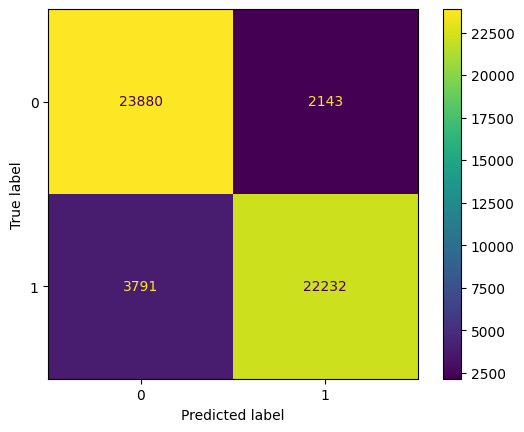

In [36]:
# Make confusion matrix to view metrics
conf_matrix(xgb_cv, X_test, y_test)

Model better at predicting postive Exits. Moving on to next step.

In [62]:
# Import final test data
df_final = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

In [63]:
# Transform test data into format that our model uses.

df_final = df_final.drop(['Age', 'Surname', 'Gender', 'CustomerId'], axis=1)

df_final = df_final.rename(columns = {'Balance' : 'balance', 'NumOfProducts' : 'num_products', 'HasCrCard' : 'cc', 
                            'IsActiveMember' : 'active', 'EstimatedSalary' : 'salary', 'Geography' : 'geo'})

df_final = pd.get_dummies(df_final)

df_final = df_final.rename(columns = {'geo_France' : 'geo_fr', 'geo_Germany' : 'geo_ger', 'geo_Spain' : 'geo_sp'})

df_final = df_final.astype({'geo_fr' : int, 'geo_ger' : int, 'geo_sp' : int})

df_final['new'] = df_final['Tenure'].copy()

df_final['middle'] = df_final['Tenure'].copy()

df_final['old'] = df_final['Tenure'].copy()

df_final['new'] = df_final.apply(new, axis=1)

df_final['middle'] = df_final.apply(middle, axis=1)

df_final['old'] = df_final.apply(old, axis=1)

df_final = df_final.drop(['Tenure'], axis = 1)

df_final.head(10)

,id,CreditScore,balance,num_products,cc,active,salary,geo_fr,geo_ger,geo_sp,new,middle,old
0,165034,586,0.00,2,0.0,1.0,160976.75,1,0,0,1,0,0
1,165035,683,0.00,1,1.0,0.0,72549.27,1,0,0,1,0,0
2,165036,656,0.00,2,1.0,0.0,138882.09,1,0,0,0,0,1
3,165037,681,0.00,1,1.0,0.0,113931.57,1,0,0,0,0,1
4,165038,752,121263.62,1,1.0,0.0,139431.00,0,1,0,0,0,1
5,165039,593,0.00,2,0.0,0.0,51907.72,1,0,0,0,0,1
6,165040,682,0.00,2,1.0,1.0,157878.67,0,0,1,0,1,0
7,165041,539,0.00,2,1.0,1.0,126784.29,0,0,1,0,0,1
8,165042,845,111096.91,1,1.0,0.0,94978.10,1,0,0,1,0,0
9,165043,645,0.00,2,0.0,1.0,149195.44,0,0,1,0,1,0


In [64]:
# Redefine X_test for our model using the df_final datset
X_test = df_final

In [65]:
# Get probability output for model
prob_final = xgb_cv.predict_proba(X_test)
prob_final[:10]


array([[0.9602875 , 0.03971248],
       [0.4291497 , 0.5708503 ],
       [0.9341216 , 0.06587838],
       [0.5031159 , 0.4968841 ],
       [0.35517263, 0.64482737],
       [0.9083383 , 0.09166169],
       [0.9811446 , 0.01885542],
       [0.9713986 , 0.02860138],
       [0.7192711 , 0.28072888],
       [0.9724457 , 0.02755427]], dtype=float32)

In [66]:
# Output verification for previous step
xgb_cv.predict(X_test)

array([0, 1, 0, ..., 0, 0, 0])

In [67]:
# Remove first number in each pair for predict_proba output
prob_final = [prob[1] for prob in prob_final]
prob_final[:10]

[0.039712485,
 0.5708503,
 0.06587838,
 0.4968841,
 0.64482737,
 0.09166169,
 0.018855417,
 0.02860138,
 0.28072888,
 0.027554268]

In [68]:
# Add probability to newly instantiated Exited column
df_final['Exited'] = prob_final

In [69]:
# Drop all columns except id and Exited, as per stakeholder request.
df_final = df_final[['id','Exited']]
df_final.head()

,id,Exited
0,165034,0.039712
1,165035,0.570850
2,165036,0.065878
3,165037,0.496884
4,165038,0.644827


In [70]:
# Make it into a csv and we're done!

df_final.to_csv('ExitedProbability.csv',index=False)